In [9]:
!pip install ../../gentrain/.

Processing /Users/benkraling/code/thesis/gentrain
  Preparing metadata (setup.py) ... done
  Created wheel for gentrain: filename=gentrain-0.1.2-py3-none-any.whl size=26704 sha256=a196f84e8c0d6ce181e978cc39cb8369a4be1439f0c9188ceb83d08128acbbf7
  Stored in directory: /private/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/pip-ephem-wheel-cache-q8wsub72/wheels/cf/e4/57/91c03db2e8c043adeefe35dd0969d3049f61ae0218be0acc9f
Successfully built gentrain
  Attempting uninstall: gentrain
    Found existing installation: gentrain 0.1.2
    Uninstalling gentrain-0.1.2:
      Successfully uninstalled gentrain-0.1.2


In [10]:
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import pandas as pd
from gentrain.encoding import get_mutation_sensitive_encodings
from gentrain.candidate_sourcing import bitwise_xor_candidates, and_or_lsh, get_hnsw_candidates
from gentrain.graph import build_mst, export_graph_gexf, get_outbreak_community_labels, build_graph, mean_edge_weight
from gentrain.evaluation import get_candidate_evaluation_and_export_mst
import os
import shutil

In [12]:
aggregate = "nrw_2022"
size = 10000

In [13]:
graph_path = f"graphs/{aggregate}/{size}"
if os.path.exists(f"graphs/{aggregate}/{size}") and os.path.isdir(f"graphs/{aggregate}/{size}"):
    shutil.rmtree(f"graphs/{aggregate}/{size}")
if not os.path.exists(f"graphs/{aggregate}"):
    os.mkdir(f"graphs/{aggregate}")
os.mkdir(f"graphs/{aggregate}/{size}")

In [14]:
sequences_df = pd.read_csv(f"../00_data_understanding_and_preparation/aggregates/{aggregate}/{size}/sequences_and_metadata.csv", delimiter=";").set_index("igs_id").sort_index()
sequences_count = len(sequences_df)
calculations_count = (sequences_count*(sequences_count-1))/2

In [15]:
distance_matrix_df = pd.read_csv(f"../01_algorithm_optimization/distance_matrices/{aggregate}/{size}/distance_matrix.csv", delimiter=";",
                                     index_col="Unnamed: 0").sort_index()
distance_matrix_df = distance_matrix_df[~distance_matrix_df.index.duplicated(keep='first')]
distance_matrix_df = distance_matrix_df.loc[sequences_df.index, sequences_df.index]
distance_matrix = distance_matrix_df.to_numpy()

In [16]:
gentrain_graph = build_graph(distance_matrix)
gentrain_mst = build_mst(gentrain_graph)

mst generation time: 2660.67s


In [17]:
gentrain_community_labels = get_outbreak_community_labels(gentrain_mst)
datetime_sampling_dates = pd.to_datetime(sequences_df["date_of_sampling"])
numeric_dates = (datetime_sampling_dates - datetime_sampling_dates.min()).dt.days
export_graph_gexf(gentrain_mst, gentrain_community_labels, sequences_df, f"{graph_path}/gentrain")

In [18]:
encodings = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=True, filter_N=True)
encodings_length = len(encodings[0])

execution time: 114.95s


In [19]:
encodings_length

6328

In [20]:
accurate_evaluation = {}
for calculation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    accurate_candidates, runtime = bitwise_xor_candidates(encodings, int(calculation_rate * calculations_count), "depth")
    accurate_evaluation[calculation_rate] = get_candidate_evaluation_and_export_mst(f"accurate_candidates_{calculation_rate}", accurate_candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime)

execution time xor distance calculation: 412.54s
execution time depth search: 253.13s
execution time 49995: 675.1s
mst generation time: 0.08s
execution time xor distance calculation: 408.5s
execution time depth search: 264.28s
execution time 499950: 681.63s
mst generation time: 1.0s
execution time xor distance calculation: 409.42s
execution time depth search: 266.39s
execution time 999900: 685.31s
mst generation time: 19.84s
execution time xor distance calculation: 410.45s
execution time depth search: 283.2s
execution time 1499850: 704.67s
mst generation time: 69.37s
execution time xor distance calculation: 408.54s
execution time depth search: 278.68s
execution time 1999800: 696.07s
mst generation time: 81.16s
execution time xor distance calculation: 408.77s
execution time depth search: 281.21s
execution time 2499750: 698.96s
mst generation time: 93.8s
execution time xor distance calculation: 408.23s
execution time depth search: 281.4s
execution time 2999700: 698.47s
mst generation tim

In [21]:
approximate_evaluation = {}
for hash_length in [2000, 3000, 4000]:
    approximate_evaluation[hash_length] = {}
    for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        print(hash_length, iterations)
        approximate_lsh_candidates = and_or_lsh(encodings, hash_length, iterations)
        approximate_evaluation[hash_length][iterations] = get_candidate_evaluation_and_export_mst(f"approximate_candates_{hash_length}_{iterations}", approximate_lsh_candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]),sequences_df, 0)

2000 1
xor lsh execution time: 1.42
mst generation time: 18.31s
2000 2
xor lsh execution time: 2.9
mst generation time: 47.63s
2000 4
xor lsh execution time: 5.68
mst generation time: 56.73s
2000 8
xor lsh execution time: 12.16
mst generation time: 128.19s
2000 16
xor lsh execution time: 23.2
mst generation time: 128.66s
2000 32
xor lsh execution time: 66.4
mst generation time: 181.35s
2000 64
xor lsh execution time: 92.28
mst generation time: 231.96s
2000 128
xor lsh execution time: 182.71
mst generation time: 277.17s
2000 256
xor lsh execution time: 365.45
mst generation time: 387.97s
3000 1
xor lsh execution time: 2.03
mst generation time: 0.16s
3000 2
xor lsh execution time: 4.1
mst generation time: 0.24s
3000 4
xor lsh execution time: 8.32
mst generation time: 29.04s
3000 8
xor lsh execution time: 25.36
mst generation time: 47.35s
3000 16
xor lsh execution time: 42.81
mst generation time: 58.05s
3000 32
xor lsh execution time: 84.73
mst generation time: 70.36s
3000 64
xor lsh exec

In [22]:
hnsw_evaluation = {}
for calculation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,  0.08, 0.09, 0.1, 0.15]:
    hnsw_candidates, runtime = get_hnsw_candidates(encodings, int(calculation_rate * calculations_count))
    hnsw_evaluation[calculation_rate] = get_candidate_evaluation_and_export_mst(f"hnsw_candidates_{calculation_rate}", hnsw_candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime)

execution time 49995: 16.96s
mst generation time: 0.04s
execution time 499950: 17.0s
mst generation time: 16.6s
execution time 999900: 18.91s
mst generation time: 33.97s
execution time 1499850: 20.62s
mst generation time: 43.36s
execution time 1999800: 22.36s
mst generation time: 52.18s
execution time 2499750: 23.57s
mst generation time: 53.57s
execution time 2999700: 24.9s
mst generation time: 63.08s
execution time 3499650: 26.01s
mst generation time: 73.14s
execution time 3999600: 27.31s
mst generation time: 83.62s
execution time 4499550: 28.51s
mst generation time: 84.93s
execution time 4999500: 29.5s
mst generation time: 94.28s
execution time 7499250: 34.37s
mst generation time: 103.75s


In [23]:
pd.DataFrame(approximate_evaluation[2000]).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
1,0.007988,0.417300,1.0,1.0,0.417300,0.0,2.614429,-0.401012,23.0,5322.0,0.073700,0.986536,0.022836
2,0.015539,0.463186,1.0,1.0,0.463186,0.0,3.020475,0.005034,25.0,3348.0,0.118965,0.980100,0.016400
4,0.022682,0.685982,1.0,1.0,0.685982,0.0,2.994466,-0.020975,39.0,1796.0,0.187981,0.975641,0.011941
8,0.093863,0.871558,1.0,1.0,0.871558,0.0,3.200731,0.185290,35.0,700.0,0.339910,0.966759,0.003059
16,0.096508,0.937098,1.0,1.0,0.937098,0.0,3.066967,0.051525,31.0,337.0,0.499625,0.971864,0.008164
32,0.159293,0.966897,1.0,1.0,0.966897,0.0,3.045838,0.030396,30.0,161.0,0.648212,0.970690,0.006990
64,0.251457,0.990434,1.0,1.0,0.990434,0.0,3.024694,0.009253,41.0,99.0,0.787407,0.964877,0.001177
128,0.298199,0.994319,1.0,1.0,0.994319,0.0,3.034913,0.019471,47.0,61.0,0.875218,0.963399,-0.000301
256,0.387223,0.997507,1.0,1.0,0.997507,0.0,3.032222,0.016781,34.0,41.0,0.923699,0.964666,0.000966


In [24]:
pd.DataFrame(approximate_evaluation[3000]).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
1,0.002521,0.320598,1.0,1.0,0.320598,0.0,2.166909,-0.848533,23.0,6697.0,0.037664,0.986771,0.023071
2,0.003469,0.373964,1.0,1.0,0.373964,0.0,2.370636,-0.644806,16.0,5566.0,0.061091,0.986264,0.022564
4,0.014272,0.646994,1.0,1.0,0.646994,0.0,2.682824,-0.332617,32.0,3549.0,0.121363,0.979706,0.016006
8,0.014040,0.676764,1.0,1.0,0.676764,0.0,2.738184,-0.277257,27.0,2455.0,0.157548,0.979333,0.015633
16,0.024802,0.791060,1.0,1.0,0.791060,0.0,2.862706,-0.152736,27.0,1441.0,0.210970,0.983004,0.019304
32,0.036225,0.850020,1.0,1.0,0.850020,0.0,2.973765,-0.041677,25.0,871.0,0.295695,0.977167,0.013467
64,0.060438,0.931938,1.0,1.0,0.931938,0.0,2.989645,-0.025797,26.0,507.0,0.394982,0.975633,0.011933
128,0.079065,0.923155,1.0,1.0,0.923155,0.0,2.999276,-0.016166,25.0,338.0,0.399281,0.976996,0.013296
256,0.115160,0.975274,1.0,1.0,0.975274,0.0,3.002579,-0.012862,42.0,229.0,0.595976,0.970174,0.006474


In [25]:
pd.DataFrame(approximate_evaluation[4000]).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
1,0.000708,0.201113,1.0,1.0,0.201113,0.0,1.743341,-1.272100,10.0,7905.0,0.019425,0.993843,0.030143
2,0.001458,0.314424,1.0,1.0,0.314424,0.0,1.860109,-1.155333,14.0,7052.0,0.032009,0.991998,0.028298
4,0.001642,0.332048,1.0,1.0,0.332048,0.0,2.060111,-0.955331,17.0,6024.0,0.052081,0.987944,0.024244
8,0.003658,0.458085,1.0,1.0,0.458085,0.0,2.297511,-0.717931,18.0,4657.0,0.071661,0.981618,0.017918
16,0.007046,0.604934,1.0,1.0,0.604934,0.0,2.441382,-0.574060,20.0,3444.0,0.112691,0.985687,0.021987
32,0.009570,0.702997,1.0,1.0,0.702997,0.0,2.523833,-0.491608,19.0,2628.0,0.164359,0.984748,0.021048
64,0.016536,0.786596,1.0,1.0,0.786596,0.0,2.656644,-0.358797,21.0,1895.0,0.202905,0.986561,0.022861
128,0.021523,0.794916,1.0,1.0,0.794916,0.0,2.785592,-0.229849,26.0,1324.0,0.221786,0.984722,0.021022
256,0.031399,0.869181,1.0,1.0,0.869181,0.0,2.874780,-0.140662,21.0,920.0,0.278089,0.980987,0.017287


In [26]:
pd.DataFrame(hnsw_evaluation).T

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
0.001,0.000362,0.069337,1.0,1.0,0.069337,16.96,4.387940,1.372498,77.0,1244.0,0.119414,0.940769,-0.022931
0.010,0.005129,0.391588,1.0,1.0,0.391588,17.00,3.658565,0.643124,74.0,18.0,0.181280,0.966550,0.002850
0.020,0.010191,0.521740,1.0,1.0,0.521740,18.91,3.412530,0.397088,74.0,8.0,0.220981,0.972981,0.009281
0.030,0.015422,0.621804,1.0,1.0,0.621804,20.62,3.354657,0.339216,74.0,5.0,0.232768,0.976291,0.012591
0.040,0.020647,0.676996,1.0,1.0,0.676996,22.36,3.318506,0.303064,74.0,3.0,0.260106,0.977395,0.013695
0.050,0.025891,0.725868,1.0,1.0,0.725868,23.57,3.289568,0.274126,74.0,2.0,0.282525,0.968597,0.004897
0.060,0.031037,0.756015,1.0,1.0,0.756015,24.90,3.267534,0.252092,74.0,2.0,0.314817,0.970397,0.006697
0.070,0.036203,0.782364,1.0,1.0,0.782364,26.01,3.256396,0.240954,74.0,1.0,0.324052,0.967200,0.003500
0.080,0.041320,0.805148,1.0,1.0,0.805148,27.31,3.240694,0.225253,74.0,1.0,0.354164,0.971500,0.007800
0.090,0.046427,0.821149,1.0,1.0,0.821149,28.51,3.229743,0.214301,74.0,1.0,0.364013,0.971800,0.008100


## Evaluation

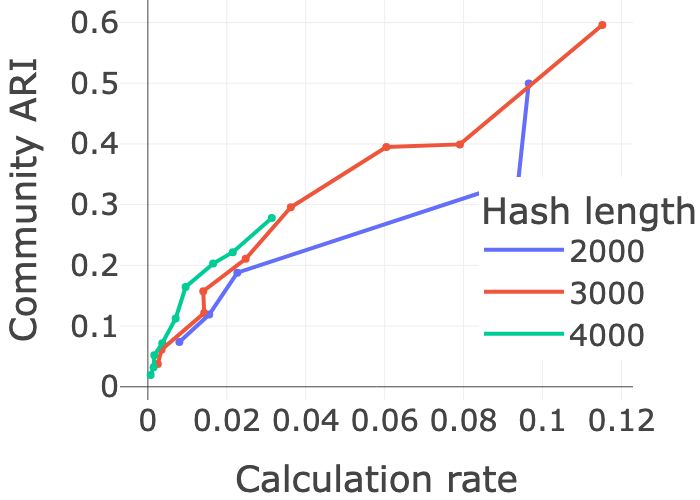

In [27]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = {}
ari = {}

for index, hash_length in enumerate([2000, 3000, 4000]):
    computation_rates[hash_length] = []
    ari[hash_length] = []
    for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        if approximate_evaluation[hash_length][iterations]["computation_rate"] <= 0.15:
            computation_rates[hash_length].append(approximate_evaluation[hash_length][iterations]["computation_rate"])
            ari[hash_length].append(approximate_evaluation[hash_length][iterations]["adjusted_rand_index"])
            fig.add_trace(go.Scatter(
                x=[approximate_evaluation[hash_length][iterations]["computation_rate"]],
                y=[approximate_evaluation[hash_length][iterations]["adjusted_rand_index"]],
                mode='markers',
                showlegend=False,
                marker=dict(color=pc.qualitative.Plotly[index], size=8),
            ))

for index, hash_length in enumerate([2000, 3000, 4000]):
    fig.add_trace(go.Scatter(
        x=computation_rates[hash_length],
        y=ari[hash_length],
        mode='lines',
        name=hash_length,
        line=dict(color=pc.qualitative.Plotly[index], width=4, dash="solid"),
    ))

fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Community ARI',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="Hash length",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
      legend=dict(
        itemwidth=80,
        x=0.7,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_hash_lengths_ari_nrw_2022.svg", width=1000, height=800)

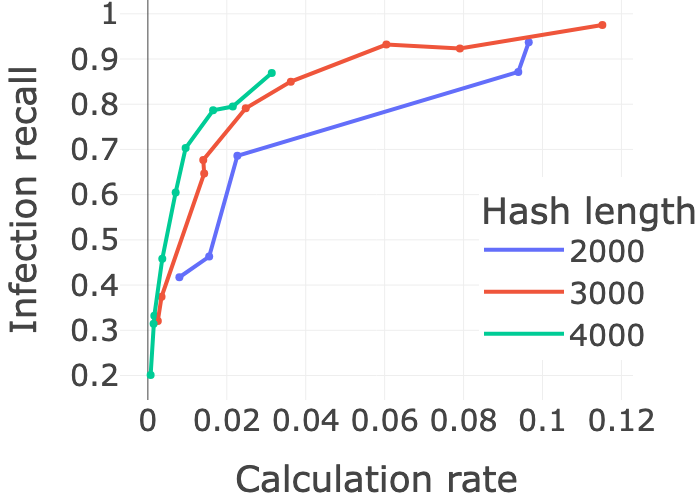

In [28]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = {}
infection_detection_rates = {}

for index, hash_length in enumerate([2000, 3000, 4000]):
    computation_rates[hash_length] = []
    infection_detection_rates[hash_length] = []
    for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
        if approximate_evaluation[hash_length][iterations]["computation_rate"] < 0.15:
            computation_rates[hash_length].append(approximate_evaluation[hash_length][iterations]["computation_rate"])
            infection_detection_rates[hash_length].append(approximate_evaluation[hash_length][iterations]["infection_detection_rate"])
            fig.add_trace(go.Scatter(
                x=[approximate_evaluation[hash_length][iterations]["computation_rate"]],
                y=[approximate_evaluation[hash_length][iterations]["infection_detection_rate"]],
                mode='markers',
                showlegend=False,
                marker=dict(color=pc.qualitative.Plotly[index], size=8),
            ))

for index, hash_length in enumerate([2000, 3000, 4000]):
    fig.add_trace(go.Scatter(
        x=computation_rates[hash_length],
        y=infection_detection_rates[hash_length],
        mode='lines',
        name=hash_length,
        line=dict(color=pc.qualitative.Plotly[index], width=4, dash="solid"),
    ))



fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Infection recall',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="Hash length",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
    legend=dict(
        itemwidth=80,
        x=0.7,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_hash_lengths_infection_recall_nrw_2022.svg", width=1000, height=800)

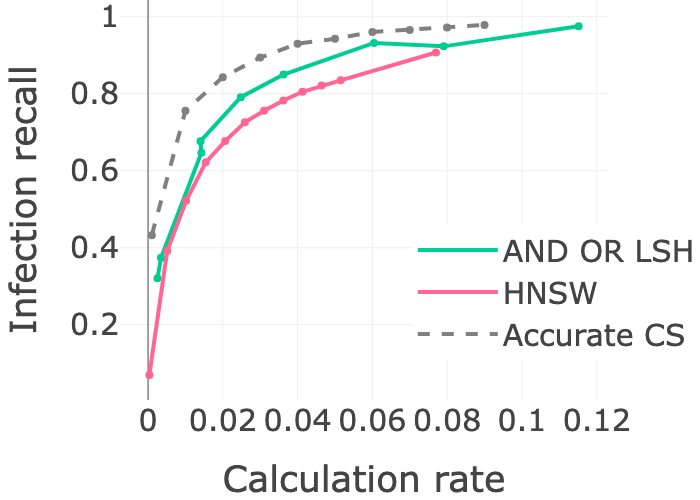

In [30]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = []
infection_detection_rates = []
for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    if approximate_evaluation[3000][iterations]["computation_rate"] < 0.15:
        computation_rates.append(approximate_evaluation[3000][iterations]["computation_rate"])
        infection_detection_rates.append(approximate_evaluation[3000][iterations]["infection_detection_rate"])
        fig.add_trace(go.Scatter(
            x=[approximate_evaluation[3000][iterations]["computation_rate"]],
            y=[approximate_evaluation[3000][iterations]["infection_detection_rate"]],
            mode='markers',
            showlegend=False,
            marker=dict(color=pc.qualitative.Plotly[2], size=8),
        ))

fig.add_trace(go.Scatter(
    x=computation_rates,
    y=infection_detection_rates,
    mode='lines',
    name="AND OR LSH",
    line=dict(color=pc.qualitative.Plotly[2], width=4, dash="solid"),
))

computation_rates_hnsw = []
ari_hnsw = []
for computation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15]:
    computation_rates_hnsw.append(hnsw_evaluation[computation_rate]["computation_rate"])
    ari_hnsw.append(hnsw_evaluation[computation_rate]["infection_detection_rate"])
    fig.add_trace(go.Scatter(
        x=[hnsw_evaluation[computation_rate]["computation_rate"]],
        y=[hnsw_evaluation[computation_rate]["infection_detection_rate"]],
        mode='markers',
        showlegend=False,
        marker=dict(color=pc.qualitative.Plotly[6], size=8),
    ))
    
fig.add_trace(go.Scatter(
    x=computation_rates_hnsw,
    y=ari_hnsw,
    mode='lines',
    name="HNSW",
    line=dict(color=pc.qualitative.Plotly[6], width=4, dash="solid"),
))

ari_accurate = []
for computation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    ari_accurate.append(accurate_evaluation[computation_rate]["infection_detection_rate"])
    fig.add_trace(go.Scatter(
        x=[computation_rate],
        y=[accurate_evaluation[computation_rate]["infection_detection_rate"]],
        mode='markers',
        showlegend=False,
        marker=dict(color="grey", size=8),
    ))

fig.add_trace(go.Scatter(
    x=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
    y=ari_accurate,
    mode='lines',
    name="Accurate CS",
    line=dict(color="grey", width=4, dash="dash"),
))


fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Infection recall',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
    legend=dict(
        itemwidth=80,
        x=0.6,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_comparison_infection_recall_nrw_2022.svg", width=1000, height=800)

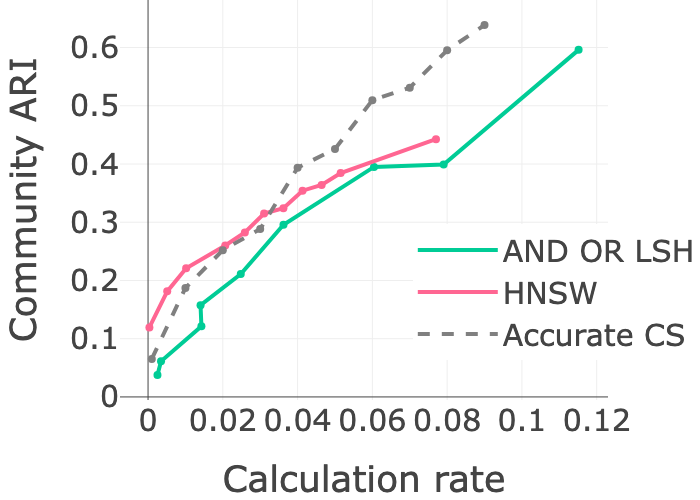

In [31]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pandas as pd
fig = go.Figure()

computation_rates = []
infection_detection_rates = []
for iterations in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    if approximate_evaluation[3000][iterations]["computation_rate"] < 0.15:
        computation_rates.append(approximate_evaluation[3000][iterations]["computation_rate"])
        infection_detection_rates.append(approximate_evaluation[3000][iterations]["adjusted_rand_index"])
        fig.add_trace(go.Scatter(
            x=[approximate_evaluation[3000][iterations]["computation_rate"]],
            y=[approximate_evaluation[3000][iterations]["adjusted_rand_index"]],
            mode='markers',
            showlegend=False,
            marker=dict(color=pc.qualitative.Plotly[2], size=8),
        ))

fig.add_trace(go.Scatter(
    x=computation_rates,
    y=infection_detection_rates,
    mode='lines',
    name="AND OR LSH",
    line=dict(color=pc.qualitative.Plotly[2], width=4, dash="solid"),
))

computation_rates_hnsw = []
ari_hnsw = []
for computation_rate in [0.001, 0.01, 0.02, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15]:
    computation_rates_hnsw.append(hnsw_evaluation[computation_rate]["computation_rate"])
    ari_hnsw.append(hnsw_evaluation[computation_rate]["adjusted_rand_index"])
    fig.add_trace(go.Scatter(
        x=[hnsw_evaluation[computation_rate]["computation_rate"]],
        y=[hnsw_evaluation[computation_rate]["adjusted_rand_index"]],
        mode='markers',
        showlegend=False,
        marker=dict(color=pc.qualitative.Plotly[6], size=8),
    ))
    
fig.add_trace(go.Scatter(
    x=computation_rates_hnsw,
    y=ari_hnsw,
    mode='lines',
    name="HNSW",
    line=dict(color=pc.qualitative.Plotly[6], width=4, dash="solid"),
))

ari_accurate = []
for computation_rate in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    ari_accurate.append(accurate_evaluation[computation_rate]["adjusted_rand_index"])
    fig.add_trace(go.Scatter(
        x=[computation_rate],
        y=[accurate_evaluation[computation_rate]["adjusted_rand_index"]],
        mode='markers',
        showlegend=False,
        marker=dict(color="grey", size=8),
    ))

fig.add_trace(go.Scatter(
    x=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
    y=ari_accurate,
    mode='lines',
    name="Accurate CS",
    line=dict(color="grey", width=4, dash="dash"),
))


fig.update_layout(
    width=1000,
    height=800,
    xaxis=dict(
        title=dict(
            text='Calculation rate',
            standoff=40
        ),
        tickangle=0
    ),
    yaxis=dict(
        title=dict(
            text='Community ARI',
            standoff=40
        ),
        tickangle=0
    ),
    legend_title="",
    template='presentation',
    font=dict(size=30),
    margin=dict(l=120,r=0,t=0,b=100),
    legend=dict(
        itemwidth=80,
        x=0.6,
        y=0.1,
        xanchor='left',
        orientation='v',
        borderwidth=0
    ),
)
fig.show()
fig.write_image("figures/approximate_cs_comparison_ari_nrw_2022.svg", width=1000, height=800)